In [2]:
import numpy as np
import matplotlib.pyplot as plt
import util
import soundfile as sf
from scipy.fft import dct

在语音识别领域有很多参数化表示语音的方法,其中Mel频谱系数(MFCC)可能是最出名最流行的方法，
其基本思路如下图所示。

<img src="http://www.ifp.illinois.edu/~minhdo/teaching/speaker_recognition/speaker_recognition_files/image008.gif" v:shapes="_x0000_s1331">

## step0. 读取音频文件
使用`soundfile`库读取音频文件, `sf.read(audio_path)`返回的是`(audio,fs)`的元组,其中`audio`是音频数据,`fs`是采样率。我们读取`data/train/s1.wav`音频并绘制其波形图。


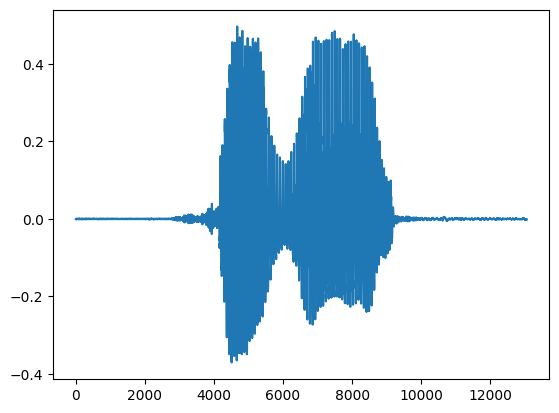

In [3]:
audio_path = r'D:\Code\python\mssb\python_version\speaker\data\train\s1.wav'
audio, fs = sf.read(audio_path)
plt.plot(audio)

## step1. 分帧
在这一步,连续的语音信号被切断成$N$个采样帧,相邻帧相隔$M$个采样点。

第一帧由前$N$个采样点组成,第二帧在第一帧后的$M$个采样点开始并与上一帧重叠$N-M$个采样点,以此类推。

通常取$N=256,M=100$，相当于约30ms的窗并且方便作**基-2 fft**

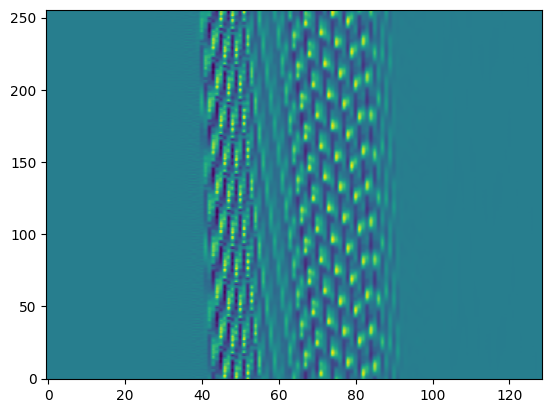

In [4]:
N, M = 256, 100
num_windows = (audio.size - N) // M + 1
frames = np.lib.stride_tricks.sliding_window_view(audio, N)[::M][:num_windows]
plt.imshow(frames.T, aspect='auto', origin='lower')

## step2. 加窗
完成分帧后下一步我们需要对每一帧加窗，将分帧导致的信号不连续的影响(频谱失真)降低到最低。

如果我们定义窗函数$w(n),0\leq n \leq N-1$,加窗后的信号可以表示为
$$y(n)=x(n)w(n),\quad 0\leq n \leq N-1$$
常见的窗函数有矩形窗、汉明窗、汉宁窗等。通常使用汉明窗，其表达式为
$$w(n)=0.54-0.4\cos\frac{2\pi n}{N-1},\quad 0\leq n \leq N-1$$

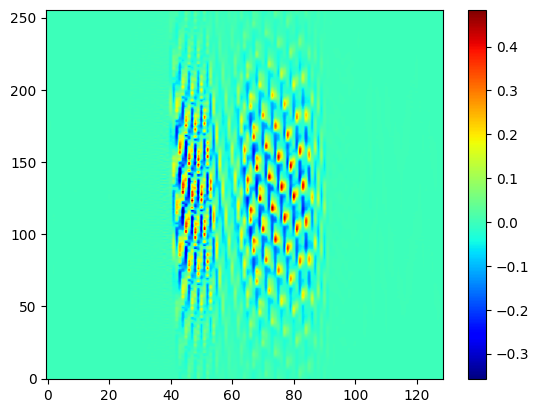

In [5]:
xn = np.arange(0, N)
wn = 0.54 - 0.46 * np.cos(2 * np.pi * xn / (N - 1))
windowed_frames = frames * wn
plt.imshow(windowed_frames.T, aspect='auto', origin='lower',cmap='jet')
plt.colorbar()

## step3. FFT
下一个步骤是对加窗后的信号进行快速傅里叶变换(FFT),得到每一帧的频谱。

FFT是一种实现离散傅里叶变换(DFT)的快速算法,将DFT的计算复杂度从$O(N^2)$降低到$O(N\log N)$，
$$X(k) = \sum_{n=0}^{N-1}x(n)e^{-j\frac{2\pi n}{N}k}$$

$X(k)$通常是复数，这里我们只关心其**功率谱密度(PSD)**,即$X(k)$的模的平方。

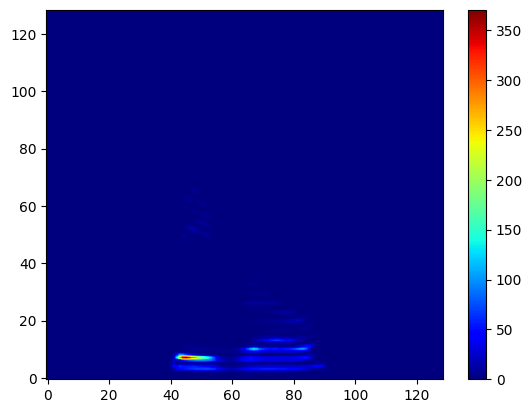

In [6]:
F = np.fft.rfft(windowed_frames, axis=1)
PSD = np.abs(F) ** 2
plt.imshow(PSD.T, aspect='auto', origin='lower',cmap='jet')
plt.colorbar()

## step5. Mel谱
研究表明，人类对语音信号中声音频率内容的感知并不是按照线性比例进行的。

因此对于以Hz为单位实际频率的每个音调的主观音高都是按Mel尺度来测量的。

Mel频率在1000Hz以下是线性的，而在1000Hz以上则是对数的。

模拟这样的主观频谱的方法是使用一个滤波器组，它在Mel尺度是均匀分布，具有三角带通性质，
其间距和带宽由恒定的Mel频率间隔决定。通常选定Mel谱系数$K$的数量为20。

<img src="http://www.ifp.illinois.edu/~minhdo/teaching/speaker_recognition/speaker_recognition_files/image026.gif" v:shapes="_x0000_s1331">

将得到的功率谱通过Mel滤波器组，得到Mel谱。

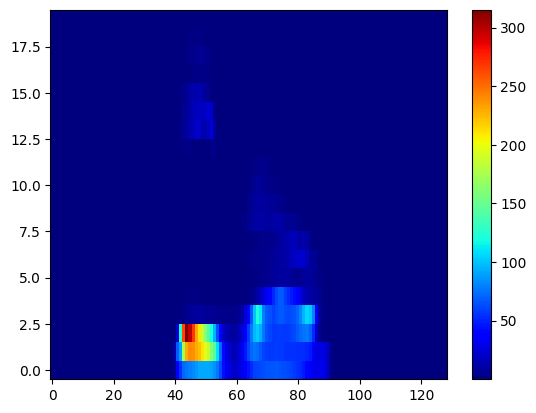

In [7]:
p = 20
bank = util.melfb(p, N, fs)
melf = bank @ PSD.T
plt.imshow(melf, aspect='auto', origin='lower',cmap='jet')
plt.colorbar()

## step6. 倒谱
所谓倒谱，就是将对数mel谱变换回时域，这一步通常使用**离散余弦变换(DCT)**完成，其结果称为**Mel频率倒谱系数(MFCC)**。

语音频谱的倒谱表示为给定的帧分析提供了信号的局部频谱特性的良好表示。

如果我们把上一步得到的经过mel滤波器组的信号记为$\widetilde S_k$，那么倒谱系数$\widetilde C_n$可以表示为
$$C_n=\sum_{k=1}^K(\log S_k)\cos[n(k-\frac{1}{2})\frac{\pi}{K}],\quad n=0,1,\cdots, K-1 $$

注意，我们要排除第一分量$\widetilde C_0$，因为它对应的是信号的平均能量，几乎不携带特征信息。

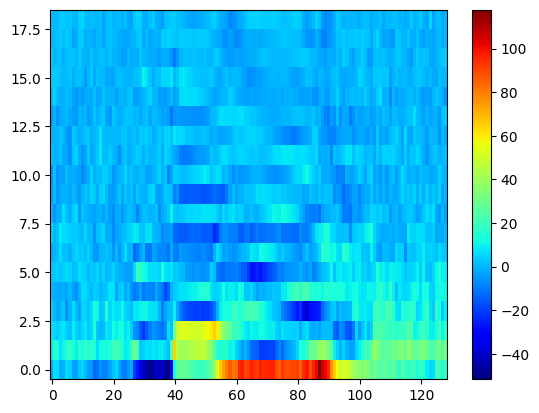

In [8]:
mfcc = dct(np.log(melf), axis=0)[1:,:]
plt.imshow(mfcc, aspect='auto', origin='lower',cmap='jet')
plt.colorbar()

最后对个答案，`librosa`库已经集成了提取音频的MFCC特征的API。

我们使用`librosa.feature.mfcc`提取音频的MFCC特征，其中`n_mfcc`是MFCC的数量，`n_fft`是FFT的窗口大小，`hop_length`是帧移。

c:\Users\34282\anaconda3\envs\mssb\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


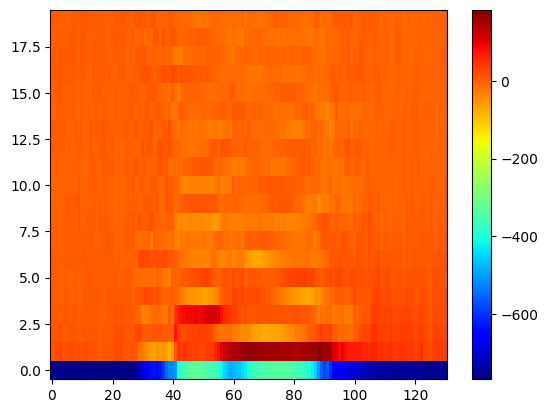

In [11]:
import librosa
standard_mfcc = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=20, n_fft=256, hop_length=100)[1:,:]
plt.imshow(standard_mfcc, aspect='auto', origin='lower',cmap='jet')
plt.colorbar()